In [4]:
%load_ext autoreload
%autoreload 2

import pickle 
import torch as th
from torch_geometric.explain import Explainer, CaptumExplainer, DummyExplainer, GNNExplainer
import torch.nn.functional as F
import torch
from torch_geometric.nn.models.basic_gnn import GraphSAGE
from torch_geometric.utils import from_dgl
import networkx as nx
import pandas as pd
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cpu')

### Setup

In [5]:
import dgl
import numpy as np

def get_batch(data):
    all_data = data.copy()
    while len(all_data) > 0:
        if len(all_data) >= 5000:
            batch = all_data.sample(5000)
            all_data = all_data.drop(batch.index)
            yield batch
        else:
            batch = all_data.copy()
            all_data = all_data.drop(batch.index)
            yield batch
            
def to_graph(data):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph())
    
    G = G.to_directed()
    # NOTE paper also uses 'i' index for each node as an identifier
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    g = g.line_graph(shared=True)
    return from_dgl(g) 

def fidelity(pred_orig, pred_masked, y):
    return  (
        np.array(pred_orig == y, dtype=int) - np.array(pred_masked == y, dtype=int)
    ).mean()


/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
test = pd.read_csv('interm/BoT_test.csv')
attrs = [c for c in test.columns if c not in ("src", "dst", "Attack", "x")]
test['x'] = test[attrs].values.tolist()
len(test['x'][0])


49

In [7]:
model = GraphSAGE(
    49,
    hidden_channels=256,
    out_channels=5,
    num_layers=3,
).to(device)

model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))
model.eval()

/tmp/ipykernel_1705/2503322102.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load('interm/GraphSAGE_BoTIoT.pth'))


GraphSAGE(49, 5, num_layers=3)

### GNNEx, DE

In [8]:
import copy
from tqdm import tqdm
from torch_geometric.data import Batch
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain.algorithm import DummyExplainer
from torch_geometric.explain import Explainer, ModelConfig
from torch_geometric.explain.algorithm import CaptumExplainer, GNNExplainer, GraphMaskExplainer

def expl(explainer, data):
    explanations = []
    for batch in tqdm(get_batch(data), total=np.ceil(len(data) / 5_000)):
        batch_graph = to_graph(batch)
        explanations.append(
            explainer(
                x=batch_graph.x.to(device),
                edge_index=batch_graph.edge_index.to(device),
            )
        )
        
    return explanations 

explanations, explainers = {}, {}

for name, explainer_object in {
    'DE': DummyExplainer(),
    'GNNE': GNNExplainer(100),
    # 'GM': GraphMaskExplainer(2, epochs=5),
    # 'IG': CaptumExplainer( 'IntegratedGradients'),
    # 'SA': CaptumExplainer('Saliency')
}.items():

    print(name)
    explainer = Explainer(
        model=model,
        algorithm=explainer_object,
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type=None,
        model_config=ModelConfig(
            mode='multiclass_classification',
            task_level='node',
            return_type='raw',
        ),
    )
    explainers[name] = explainer
    explanations[name] = expl(
        data=test,
        explainer=explainer
    )
    

DE


  0%|          | 0/3.0 [00:00<?, ?it/s]

100%|██████████| 3/3.0 [00:03<00:00,  1.30s/it]


GNNE


100%|██████████| 3/3.0 [02:29<00:00, 49.93s/it]


### IG

In [9]:
import torch
from tqdm import tqdm

def integrated_gradients(x, edge_index, model, baseline, steps):
    device = x.device
    if baseline is None:
        baseline = torch.zeros_like(x, device=device)

    diff = x - baseline
    total_grads = torch.zeros_like(x, device=device)

    for alpha in torch.linspace(0.0, 1.0, steps, device=device):
        x_scaled = baseline + alpha * diff
        x_scaled.requires_grad_(True)

        # forward pass
        out = model(x_scaled, edge_index)
        
        # pick the logit for each root node & assume root nodes are first B rows
        # batch_size = targets.size(0)
        # sel = out[:batch_size, :] 
        # chosen = sel[torch.arange(batch_size), targets]

        # sum to get a scalar and backprop
        model.zero_grad()
        torch.autograd.backward(out.sum(), retain_graph=True)
        grads = x_scaled.grad

        total_grads += grads
        x_scaled.grad.zero_()

    # average gradient then scale by input delta
    avg_grads = total_grads / steps
    attributions = diff * avg_grads 

    return attributions


model.eval()
all_attr, all_delta = [], []
explanations['IG'] = []

for G in tqdm(get_batch(test)):
    G = to_graph(G)
    G = G.to(device)
    x = G.x
    edge_index = G.edge_index

    # compute attributions
    ig_attr = integrated_gradients(
        x=x,
        edge_index=edge_index,
        # targets=targets,
        model=model,
        baseline=torch.zeros_like(x),
        steps=100
    )

    explanations['IG'].append(ig_attr)


0it [00:00, ?it/s]

3it [02:23, 47.99s/it]


### Eval

In [10]:
explainers['DE'], explanations['DE']

(<torch_geometric.explain.explainer.Explainer at 0x7f393065c750>,
 [Explanation(node_mask=[10000, 49], prediction=[10000, 5], target=[10000], x=[10000, 49], edge_index=[2, 636658]),
  Explanation(node_mask=[10000, 49], prediction=[10000, 5], target=[10000], x=[10000, 49], edge_index=[2, 600742]),
  Explanation(node_mask=[9760, 49], prediction=[9760, 5], target=[9760], x=[9760, 49], edge_index=[2, 584006])])

GNNE/DE fidelity soft mask

In [ ]:
#  ! crashes immediantly ??? 

from torch_geometric.explain import metric

for ex in ('DE', 'GNNE'):
    print(ex)
    f_pluses, f_minuses = [], []
    for i in range(len(explanations['DE'])):   
        f_plus, f_minus = metric.fidelity(
            explainers[ex], explanations[ex][i])
        
        f_pluses.append(f_plus)
        f_minuses.append(f_minuses)

    print(f'{ex}: {np.array(f_pluses).mean()} {np.array(f_minuses).mean()}')

DE


GNNE/DE sparsity/fidelity-acc curves (just do tables)

IG metrics (uses attributions)

In [ ]:
import numpy as np

fidelity_plus, fidelity_minus = {}, {}

for batch, attr in tqdm(zip(get_batch(test), explanations['IG'])):
    G = to_graph(batch)
    
    G = G.to(device)
    x = G.x.clone()
    y = G.Attack.clone()
    edge_index = G.edge_index
    targets = G.Attack

    # pred
    with torch.no_grad():
        out_orig = model(x, edge_index)
        pred_orig = out_orig.argmax(dim=1)
        
    for sparsity_percent in np.arange(0, 0.2, 5e-4):
        abs_attr = attr.abs()
        k = int(sparsity_percent * x.size(1))
        topk_idx = abs_attr.topk(k, dim=1).indices

        mask = torch.zeros_like(attr, device=device) 
        mask.scatter_(1, topk_idx, 1) 

        # Mask input features
        x_masked = x.clone()
        x_masked *= mask 

        # Prediction after masking
        with torch.no_grad():
            out_masked = model(x_masked, edge_index)
            pred_masked = out_masked.argmax(dim=1)
            
        # TODO also do fid+
        # !! overwrites at each batch
        fidelity_minus[sparsity_percent] = fidelity(pred_orig, pred_masked, G.Attack)
        

0it [00:00, ?it/s]

/tmp/ipykernel_1108839/952155181.py:30: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(pred_orig == y, dtype=int) - np.array(pred_masked == y, dtype=int)
3it [06:02, 120.84s/it]


(0.0, 0.4)

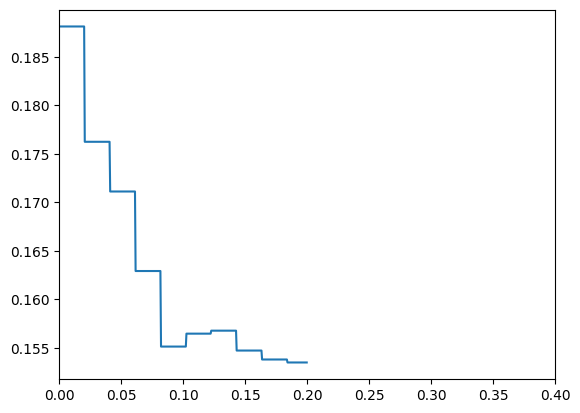

In [27]:
import matplotlib.pyplot as plt

plt.plot(*zip(*fidelity_minus.items()))
plt.xlim((0, 0.4))

! sparsity can be inferred from attribution lists - can likely also be computed from sp. percent 